Importing all the necessory files


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Importing the data set and looking at its attributes

In [2]:
sales = pd.read_csv("train.csv")
sales.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Checking the basic information on our data like the null values and data types of the attributes etc.

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Dropping the unecessory attributes and checking the info again

In [4]:
sales = sales.drop(['store', 'item'], axis = 1)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


Converting date from object data type to datatime data type

In [5]:
sales['date'] = pd.to_datetime(sales['date'])

Converting date into a month period and then adding the number of items in each month

In [6]:
sales['date'] = sales['date'].dt.to_period('M')

In [7]:
monthly_sales = sales.groupby('date').sum().reset_index()

Converting resulting date column to timestamp data type 

In [8]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [9]:
monthly_sales.head(5)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


Visualization

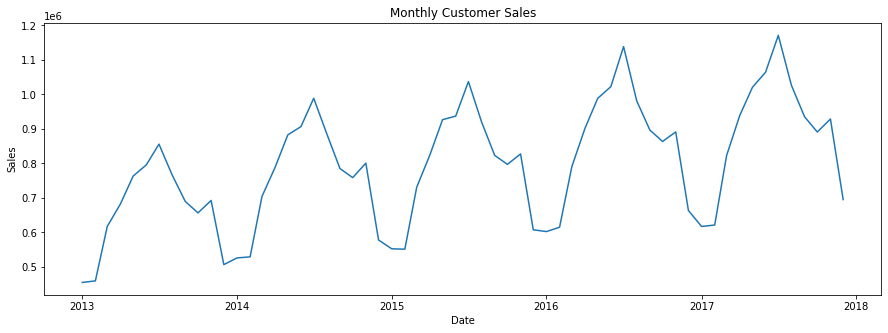

In [10]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

To make the data sales data stationary, we will call the difference on sales column

In [11]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(5)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


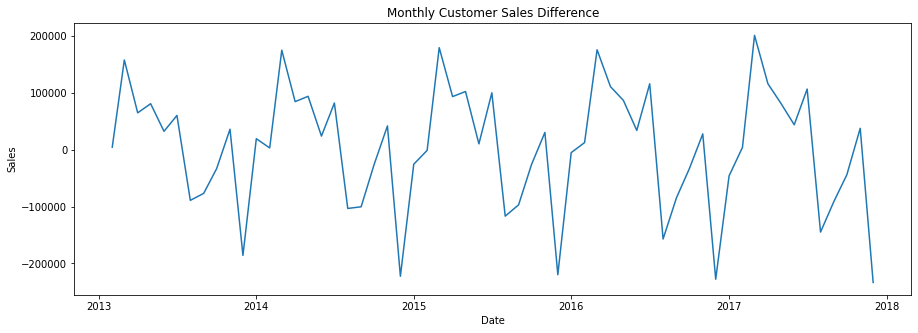

In [12]:
plt.figure(figsize = (15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales Difference')
plt.show()

Dropping the attributes 'Sales', and 'Date'

In [13]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis = 1)

Preparing supervised data

In [14]:
for i in range (1, 13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop = True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Splitting Data into train and test data set

In [15]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [16]:
scaler = MinMaxScaler(feature_range = (-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data) 

In [17]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('x_train Shape: ', x_train.shape)
print('y_train Shape: ', y_train.shape)
print('x_test Shape: ', x_test.shape)
print('y_test Shape: ', y_test.shape)

x_train Shape:  (35, 12)
y_train Shape:  (35,)
x_test Shape:  (12, 12)
y_test Shape:  (12,)


Make prediction data frame to merge the predicted sales price of all trained algorithms

In [18]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop = True)
predict_df=pd.DataFrame(sales_dates)

In [19]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


To create linear regression model to predict sales

In [20]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [21]:
lr_pre = lr_pre.reshape(-1, 1)
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis = 1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [22]:
result_list = []
for index in range (0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name = "Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)    

In [23]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
print("Mean Squared Error: ", lr_mse)
lr_mae = (mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
print("Mean Absolute Error: ", lr_mae)
lr_r2 = (r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
print("R Square Error : ", lr_r2)

Mean Squared Error:  16221.272385416898
Mean Absolute Error:  12433.184266490765
R Square Error :  0.9906152516380968


Visualization of predicted sales vs actual sales

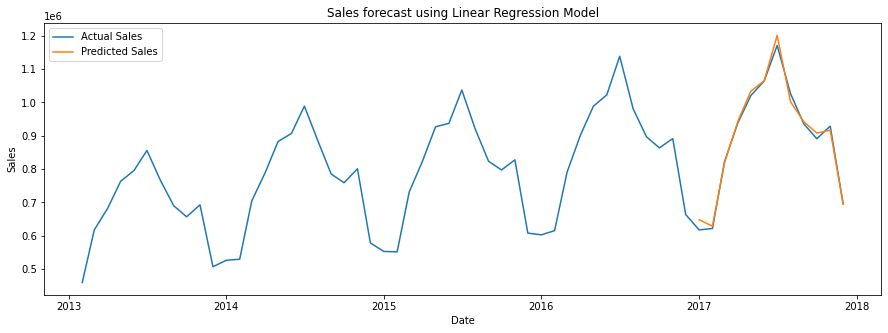

In [24]:
plt.figure(figsize = (15,5))
#Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
#Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales forecast using Linear Regression Model')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()